# Assignmet 2

### Loading libraries

In [85]:
import pickle
import json
import numpy as np
import networkx as nx
import fa2_modified as fa2
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import community.community_louvain as community
from networkx.algorithms.community.quality import modularity

## Part 1: Genres and communities and plotting 

#### **Write about genres and modularity.**

* Communities are cluster of nodes where internal connections are more frequent, while connections to nodes in other clusters/communities are less frequent. In the context of our network, country music artists, the communities are stablished according to the first genre of the artist for the first part of the assingment and then all the genres of the artist for the following part.

* Modularity quantifies how well a network is divided into communities by comparing the density of edges inside communities to edges between communities. High modularity values indicate that there are more connections within communities than would be expected in a random network with the same node degree distribution. This makes modularity a useful metric for identifying meaningful communities in networks.


#### **Detect the communities, discuss the value of modularity in comparison to the genres.**

In [2]:
def load_artist_genres_dict():
    artist_genres_dict = {}
    with open('artists_genres_dictionary.txt', 'r') as f:
        artist_genres_dict = json.load(f)
    return artist_genres_dict

artists = load_artist_genres_dict()

In [184]:
# Load the graph from the pickle file
with open('../lab5/artist_graph.pkl', 'rb') as f:
    G = pickle.load(f)

# make the graph undirected
G = G.to_undirected()

rm_nodes = []

# filter the network to only include nodes that are in the artist_genres_dict
for node in G.nodes():
    if node.replace('_', ' ') in artists.keys():
        genres = artists[node.replace('_', ' ')]
        G.nodes[node]['genre'] = genres[0]
        # selecting the first genre that is not country if possible
        # if len(genres) > 1:
        #     if genres[0] != 'country':
        #         G.nodes[node]['genre'] = genres[0]
        #     else:
        #         G.nodes[node]['genre'] = genres[1]
        # else: 
        #     rm_nodes.append(node)
    else:
        rm_nodes.append(node)

for node in rm_nodes:
    G.remove_node(node)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 1829
Number of edges: 14060


In [4]:
# Create a dictionary to hold communities based on the 'genre' attribute
communities = defaultdict(list)

# Group nodes by the 'category' attribute
for node, data in G.nodes(data=True):
    category = data['genre']
    communities[category].append(node)

# Convert communities to a list of lists
communities_list = list(communities.values())

# Calculate modularity
mod = modularity(G, communities_list)
print(F"Modularity of the graph based on library: {mod}")

# calculate modularity based on equation
# M is the modularity.
# nc is the number of communities.
# Lc is the number of edges within community 
# L is the total number of edges in the graph.
# kc is the sum of the degrees of all nodes in community 
# Total number of edges in the graph
L = G.number_of_edges()

# Modularity calculation based on the given formula
M = 0
for c in communities_list:
    # Subgraph of the current community
    subgraph = G.subgraph(c)
    
    # L_c: Number of edges inside this community
    L_c = subgraph.number_of_edges()
    
    # k_c: Sum of the degrees of the nodes in this community
    k_c = sum(dict(G.degree(c)).values())
    
    # Apply the modularity formula
    M += (L_c / L) - (k_c / (2 * L))**2

# Print the modularity
print(f"Modularity based on formula: {M}")


Modularity of the graph based on library: 0.07113789914793135
Modularity based on formula: 0.07113789914793132


In [25]:
# first compute the best partition base on Louvain-algorithm
partition = community.best_partition(G)

# calculate the modularity of the partition
mod = community.modularity(partition, G)
print(F"Modularity of the partition by Louvain-algorithm: {mod}")

Modularity of the partition by Louvain-algorithm: 0.38685797658480525


First of all the higher is M for a partition, the better is the corresponding community structure. 

In our case, for the first value of M, **0.071**, corresponds to the modularity of the artist grouped by their first genre. This value is close to zero, which indicates that the network has a weak community structure. In practice, this means that the communities (genres in our case) are not well-separated, what can be associated to the processing of the data, since `country` is the first genre for most of the artist. 

Alternatively, the modularity has also been computed for the artist that have more than one genre, selecting the second genre and there was little difference, obtaining a value of **0.079**. Therefore, the study will be based on the first assumption.

Next the modularity based on the partitions made by Louvain-algorithm is **0.383**. This algorithm does a local optimization of modularity, therefore it maximizes modularity of the given graph. This is done by quantifying the density within communities compared to between them iteratively and it moves the nodes to a neighboring community if it increases the modularity. The process is more complex but we consider this explanation graps the main idea. 

So after computing both modularities, community wise the second partition is better, due to the higher modularity.

#### **Calculate the matrix $D$ and discuss your findings.**

In [27]:
# Graph with all genres
# Load the graph from the pickle file
with open('../lab5/artist_graph.pkl', 'rb') as f:
    G_all = pickle.load(f)

# make the graph undirected
G_all = G_all.to_undirected()

rm_nodes = []

for node in G_all.nodes():
    if node.replace('_', ' ') in artists.keys():
        G_all.nodes[node]['genre'] = artists[node.replace('_', ' ')]
    else:
        rm_nodes.append(node)

for node in rm_nodes:
    G_all.remove_node(node)

In [53]:
# Graph with all genres G_all

# Apply the Louvain algorithm to detect communities
partition = community.best_partition(G_all, random_state=42)

# Identify the 7 most common genres
genres = []
genres_1 = [data['genre'] for _, data in G_all.nodes(data=True)]
for i in range(len(genres_1)):
    for genre in genres_1[i]:
        genres.append(genre)

genre_counter = Counter(genres)
top_7_genres = [g for g, _ in genre_counter.most_common(7)]
print(top_7_genres)

# Identify the 7 largest communities
community_counter = Counter(partition.values())
top_7_communities = [c for c, _ in community_counter.most_common(7)]
print(top_7_communities)

# Initialize the confusion matrix (7 x 7)
confusion_matrix = np.zeros((7, 7), dtype=int)

# Populate the confusion matrix
for node, data in G_all.nodes(data=True):
    genre = data['genre']
    c = partition[node]

    # For all genres of a node
    # Check if the genre is in the top 7 genres and the community is in the top 7 communities
    for g in genre:
        if g in top_7_genres and c in top_7_communities:
            genre_idx = top_7_genres.index(g)
            community_idx = top_7_communities.index(c)
            confusion_matrix[genre_idx, community_idx] += 1

# Display the confusion matrix
print("Confusion Matrix (Genres x Communities):")
print(confusion_matrix)

['country', 'folk', 'country rock', 'americana', 'pop', 'bluegrass', 'rock']
[0, 3, 7, 1, 6, 10, 8]
Confusion Matrix (Genres x Communities):
[[438 352 271 347  49  25   5]
 [  6  11 127  29   1   4   0]
 [ 34  51  51  21   4   9   0]
 [  9  16 107  15   1   8   0]
 [ 15  52  39  48   3   0   0]
 [ 30   8  75   9   0   5   0]
 [ 16  23  58  14   3   2   0]]


We believe that a very distinct community structure could produce a diagonal matrix (genre x communities), where the genre would be the main characteristic of the given community. But as it can be observed in our $D$ matrix and also based on the low modularity found in genre, it is not our case. Neverhteless next we are presenting some insights about the present matrix.

The `country` genre is the most common one, so artist from this genre can be found in every community. Since it is sorted based on which is the most common genre and community the largest ammount of artists can be found in the top left corner of the matrix. 

Another finding could be that communities 6 and 10 are mainly formed by artist which their first genre is `country`, so a more detailed analysis could provide what make these artist be grouped together. Fourthermore, community 8 is exclusively formed  by `country` artists.

Additionally community 7 even though its main genre is `country` artists it combines most of the artist from the `folk` and `americana` genres.

Finally, it could be said that the first four communities englobes the major portion of the artits.

#### **Plot the communities and comment on your results.**

In [79]:
# Group nodes by their community and calculate the size of each community
community_sizes = {}
for node, comm in partition.items():
    if comm not in community_sizes:
        community_sizes[comm] = 0
    community_sizes[comm] += 1

# Sort communities by size and get the largest 10 communities
largest_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[:10]

# Assign colors to nodes
# Color nodes in the largest communities with distinct colors, and others with a light gray color
node_colors = []
for node in G.nodes():
    c = partition[node]
    if c in largest_communities:
        # Assign a unique color to the community
        node_colors.append(largest_communities.index(c))
    else:
        # Assign light gray to small communities
        node_colors.append(0.85)  # Light gray

# Apply the Force Atlas 2 algorithm to layout the graph
forceatlas2 = fa2.ForceAtlas2(
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # Linear distances between nodes
    adjustSizes=False,  # Don't account for node sizes
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,  # Tolerance for node overlapping
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0
)

# Get positions for nodes using Force Atlas 2
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:55<00:00, 36.13it/s]

BarnesHut Approximation  took  4.82  seconds
Repulsion forces  took  48.09  seconds
Gravitational forces  took  0.21  seconds
Attraction forces  took  0.29  seconds
AdjustSpeedAndApplyForces step  took  1.08  seconds


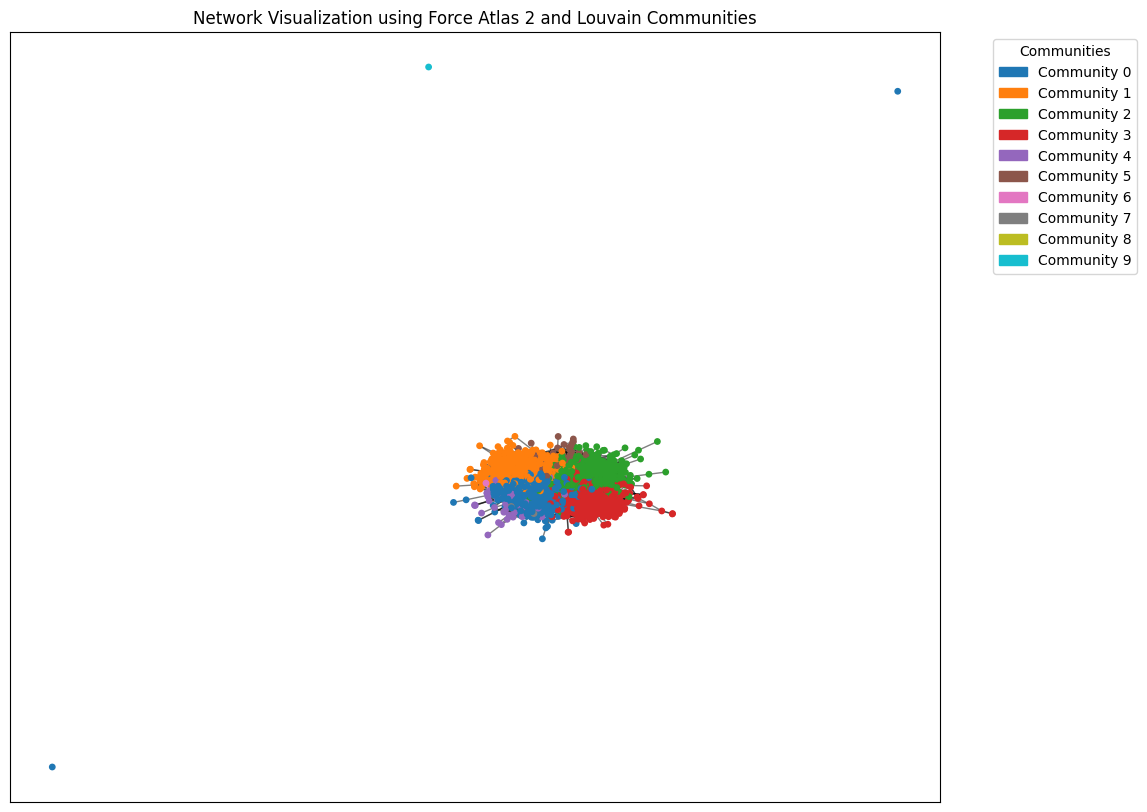

In [86]:
# Set the colormap to use 10 distinct colors
cmap = plt.cm.tab10

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 10))

# Draw nodes
nx.draw_networkx_nodes(G, positions, node_color=node_colors, cmap=cmap, node_size=15)

# Draw edges
nx.draw_networkx_edges(G, positions, alpha=0.5)

# Set title
plt.title("Network Visualization using Force Atlas 2 and Louvain Communities")

# Create custom legend with colors corresponding to integers 0–9
legend_handles = [
    mpatches.Patch(color=cmap(i), label=f'Community {i}') for i in range(10)
]
plt.legend(handles=legend_handles, title="Communities", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

<div style="text-align: justify;">
As it can be observed the communities are not clearly separated clusters, this was predictible due to value of the modularity metric. Overall, the communities seam to be overlaped. Then, doing a more in depth analysis of the data, we could find the characteristic of the communities. This would probably provide more information about the artists.
</div>

## Part 2: TF-IDF to understand genres and communities

In [60]:
import os
import string
import nltk
import math
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alicia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### **Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.**

<div style="text-align: justify;">
TF-IDF stands for Term Frequency - Inverse Document Frequency. The process involves identifying the most significant or relevant terms within a corpus of documents, such as a collection of articles or a set of web pages. This typically entails evaluating each term’s frequency and contextual relevance across documents to distinguish words that carry the most semantic weight. So this metric highlight words that are frequent within individual documents but less common across the entire corpus, thereby isolating terms likely to be more pertinent to the document’s unique content.
</div>
<br>
<div style="text-align: justify;">
This can help us understand genres and communities since we can find terminology that idenfities a scpefici group based on the TF-IDF
</div>

#### **Calculate and visualize TF-IDF for the genres and communities.**

In [61]:
# Get the top 15 genres
top_15_genres = [g for g, _ in genre_counter.most_common(15)]
print(top_15_genres)

# Just run once because it appends the data to the file
for node in G.nodes():
    genre = G.nodes[node]['genre']

    if genre in top_15_genres:
        # read the file with the node's name
        with open(f'../lab4/artist_data/{node}.txt', 'r') as f:
            data = f.read()
        
        # append the data to the genre txt file
        with open(f'genres/{genre.replace(' ', '_')}.txt', 'a') as f:
            f.write(data) 

['country', 'folk', 'country rock', 'americana', 'pop', 'bluegrass', 'rock', 'country pop', 'gospel', 'rockabilly', 'blues', 'alternative country', 'folk rock', 'southern rock', 'rock and roll']


In [62]:
# Get the top 10 communities
# Just run once because it appends the data to the file
for node in G.nodes():
    c = partition[node]

    if c in community_counter:
        # read the file with the node's name
        with open(f'../lab4/artist_data/{node}.txt', 'r') as f:
            data = f.read()
        
        # append the data to the genre txt file
        # create directory if it does not exist
        os.makedirs('communities', exist_ok=True)
        with open(f'communities/c_{c}.txt', 'a') as f:
            f.write(data) 

In [63]:
def calculate_tf_idf(input_folder, output_folder, num_documents=15):
    # Initialize lemmatizer and load stopwords
    lemmatizer = WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')

    # Define characters and syntax to filter
    quotes = ['``', "''", '’', '""', '“', '”']
    wiki_syntax = ['https', 'ref', 'url', 'n', 'wa', 'cite', "'s"]

    # n thinks
    n_scape = '\\n'

    # Initialize containers for TF and processed documents
    documents = {}      # To store the tokens of each document
    all_words = set()   # To store all unique words in the corpus

    # for every file in genres folder
    for filename in os.listdir(input_folder):
        # read the file
        with open(f'{input_folder}/{filename}', 'r') as f:
            data = f.read()
        
        # tokenize the data
        tokens = word_tokenize(data)

        # remove punctuation and make all words lowercase
        tokens = [word.lower() for word in tokens if word not in string.punctuation]

        # lemmatize the words
        tokens = [lemmatizer.lemmatize(word).lower() for word in tokens]

        # remove stopwords
        tokens = [word for word in tokens if word not in stopwords]

        # remove words that are len 1
        tokens = [word for word in tokens if len(word) > 1]

        # remove quotes
        tokens = [word for word in tokens if word not in quotes]

        # remove \n
        tokens = [word for word in tokens if n_scape not in word]

        # remove urls
        tokens = [word for word in tokens if '/' not in word]
        tokens = [word for word in tokens if 'www' not in word]
        tokens = [word for word in tokens if 'url' not in word]

        # remove words that contain = 
        tokens = [word for word in tokens if '=' not in word]

        # remove words contains : 
        tokens = [word for word in tokens if ':' not in word]

        # remove wiki syntax
        tokens = [word for word in tokens if word not in wiki_syntax]

        # count the tokens
        token_counter = Counter(tokens)

        # remove words that appear less than 5 times
        token_counter = {token: count for token, count in token_counter.items() if count >= 5}

        # Calculate term frequencies (TF)
        total_words = len(tokens)

        # save the tokens in the documents dictionary
        doc_tf = {}
        for token, count in token_counter.items():
            # calculate the frequency with .2f precision
            doc_tf[token] = count/total_words
            all_words.add(token)

        documents[filename[:-4]] = doc_tf

    idf = {}
    for word in all_words:
        # Count how many documents contain the word
        doc_count = sum(1 for doc in documents if word in doc)
        # to prevent division by zero
        idf[word] = math.log(num_documents / doc_count) if doc_count > 0 else 0

    # Calculate TF-IDF for each word in each document
    tf_idf = {}

    for doc_name, doc_tf in documents.items():
        doc_tf_idf = {}
        for word, tf in doc_tf.items():
            # Calculate TF-IDF for the word in the current document
            tf_idf_value = tf * idf[word]  # TF * IDF
            doc_tf_idf[word] = tf_idf_value
        tf_idf[doc_name] = doc_tf_idf

    # store the tf_idf in a file
    os.makedirs(output_folder, exist_ok=True)
    for doc_tf_idf, tf_idf_values in tf_idf.items():
        with open(f'{output_folder}/{doc_tf_idf}.txt', 'w') as f:
            for word, value in tf_idf_values.items():
                f.write(f"{word}   {value:.4f}\n")
    

In [64]:
calculate_tf_idf('genres', 'tf_idf_genres')

In [65]:
calculate_tf_idf('communities', 'tf_idf_communities', num_documents=10)

In [66]:
# Function to generate word cloud for a genre
def generate_wordcloud_for_genre(filename, input_folder, output_folder='wordclouds'):
    # Create a string with each word repeated based on its TF-IDF score
    word_string = ''
    
    # Read the genre file
    with open(f'{input_folder}/{filename}', 'r') as file:
        for line in file:
            word, tf_idf_value = line.split()
            tf_idf_value = float(tf_idf_value)

            # Repeat the word based on the TF-IDF score, rounded up to the nearest integer
            repeat_count = max(1, math.ceil(tf_idf_value))  # Use at least 1 if the score is very small
            word_string += (word + ' ') * repeat_count

    # Generate the word cloud
    wordcloud = WordCloud(collocations=False, background_color='white', width=800, height=600).generate(word_string)
    
    # # Create output folder if it doesn't exist
    # os.makedirs(output_folder, exist_ok=True)
    
    # # Save the word cloud as an image file
    # genre_name = os.path.splitext(filename)[0]  # Remove file extension to get genre name
    # wordcloud.to_file(f'{output_folder}/{genre_name}_wordcloud.png')
    
    # Optionally, display the word cloud
    # plt.figure(figsize=(10, 8))
    # plt.imshow(wordcloud, interpolation='bilinear')
    # plt.axis('off')
    # plt.title(f'Word Cloud for {filename[:-4]}')
    # plt.show()

    return wordcloud, filename

In [67]:
folder = 'tf_idf_genres'

wordclouds_genres = []
# Generate word clouds for each genre file in the 'tf_idf' folder
for genre_file in os.listdir(folder):
    if genre_file.endswith('.txt'):  # Make sure we're only processing text files
        wordcloud, filename = generate_wordcloud_for_genre(genre_file, folder)
        wordclouds_genres.append((wordcloud, filename))

In [68]:
folder = 'tf_idf_communities'

wordclouds_communities = []
# Generate word clouds for each genre file in the 'tf_idf' folder
for genre_file in os.listdir(folder):
    if genre_file.endswith('.txt'):  # Make sure we're only processing text files
        wordcloud, filename = generate_wordcloud_for_genre(genre_file, folder)
        wordclouds_communities.append((wordcloud, filename))

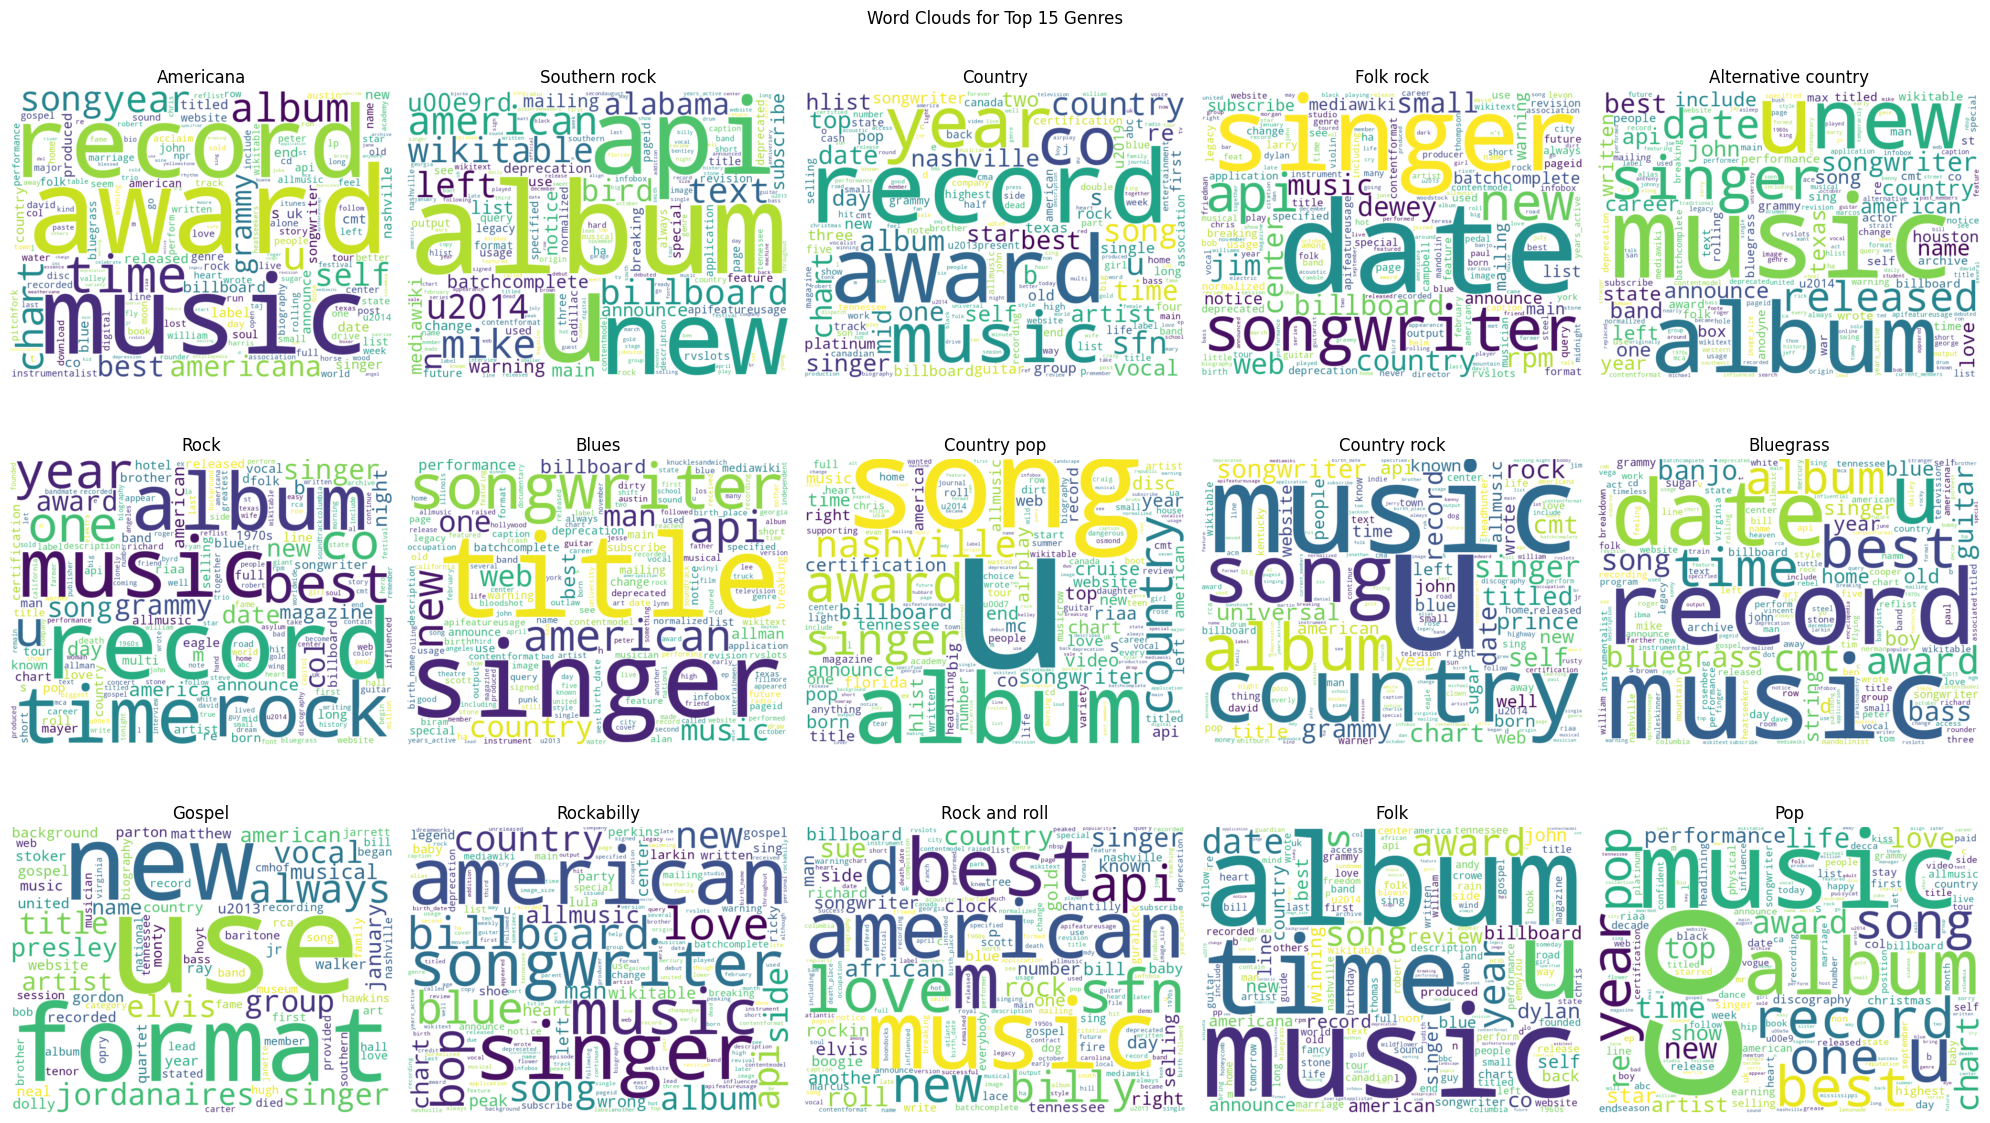

In [69]:
# Set up the grid dimensions (e.g., 3x5 for up to 15 files)
n_rows, n_cols = 3, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
# set suplot title
fig.suptitle('Word Clouds for Top 15 Genres')

# Flatten the 2D axes array for easy iteration if it’s not already 1D
axes = axes.flatten()

# Plot each word cloud on a subplot
for idx, (wordcloud, filename) in enumerate(wordclouds_genres):
    if idx >= n_rows * n_cols:  # Limit display to grid size
        break
    ax = axes[idx]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'{filename[:-4].replace("_", " ").capitalize()}')

# Hide any remaining empty subplots if wordclouds < total slots
for j in range(len(wordclouds_genres), n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

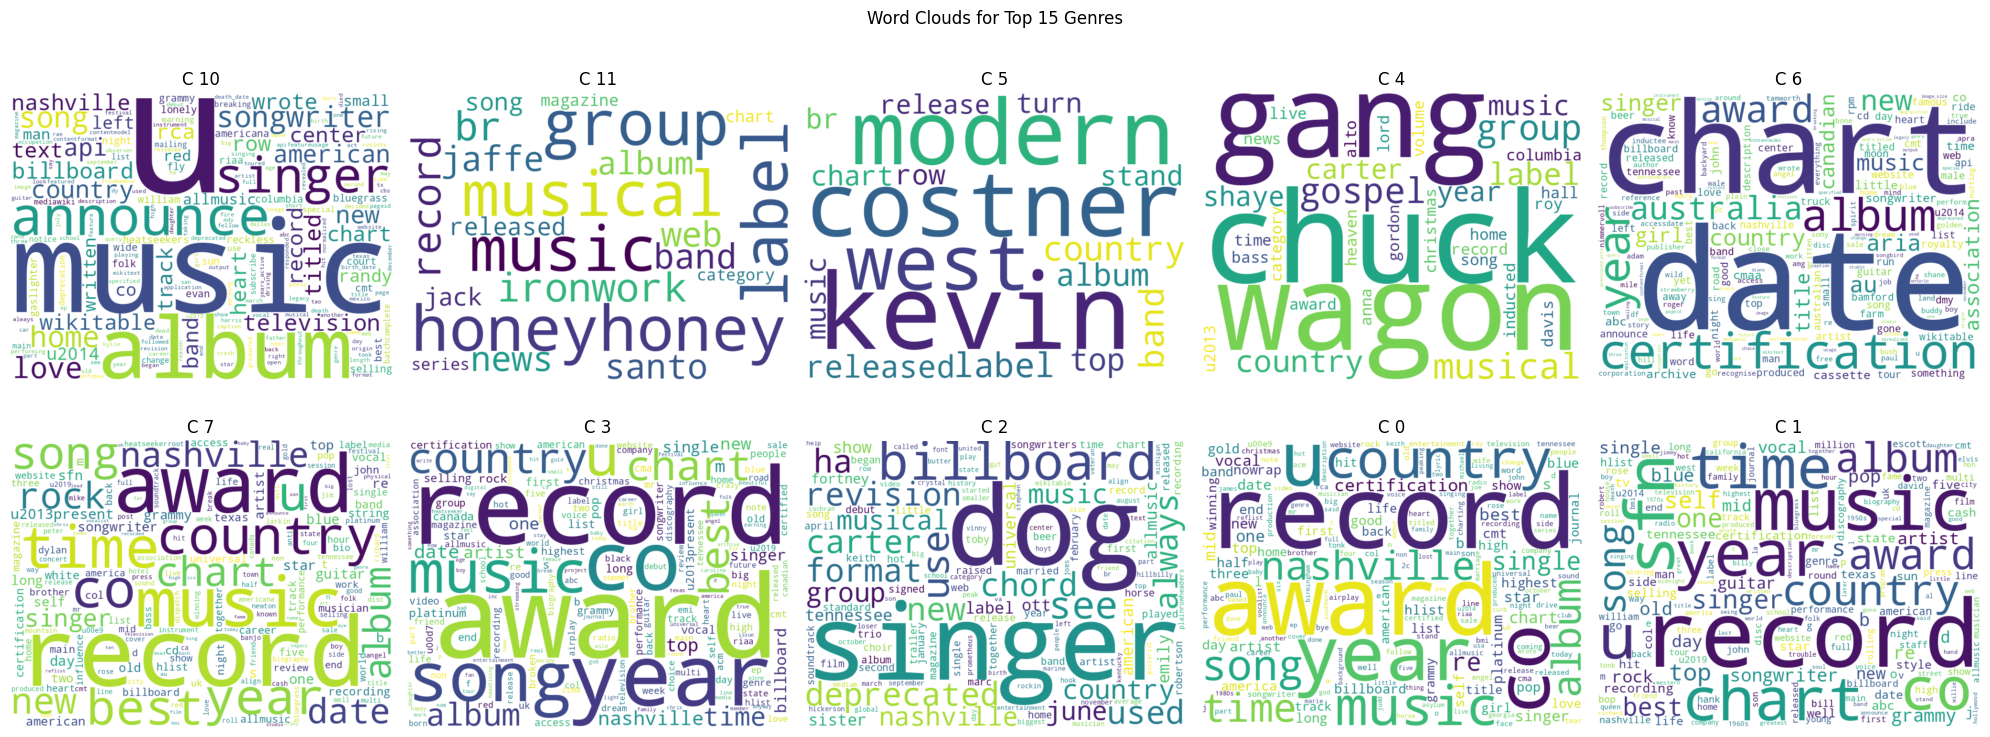

In [70]:
# Set up the grid dimensions (e.g., 3x5 for up to 15 files)
n_rows, n_cols = 2, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
# set suplot title
fig.suptitle('Word Clouds for Top 15 Genres')

# Flatten the 2D axes array for easy iteration if it’s not already 1D
axes = axes.flatten()

# Plot each word cloud on a subplot
for idx, (wordcloud, filename) in enumerate(wordclouds_communities):
    if idx >= n_rows * n_cols:  # Limit display to grid size
        break
    ax = axes[idx]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'{filename[:-4].replace("_", " ").capitalize()}')

# Hide any remaining empty subplots if wordclouds < total slots
for j in range(len(wordclouds_communities), n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

#### **Use the matrix (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.**


The word clouds for genres and communities offer two distinct perspectives on musical themes. Genre word clouds, organized by labels like "country," "rock," and "folk," focus on the defining terms most associated with each music style. For instance, genres such as "country" may frequently display terms like "record," "singer," and "album," which align with the conventional themes, instruments, and audience expectations within that genre. These word clouds provide a straightforward representation of the thematic content that characterizes each musical genre.

In contrast, the community-based word clouds reveal connections that emerge from a network perspective, where terms are grouped by patterns of association rather than predefined genre labels. These communities capture clusters that may cross genre boundaries or highlight less obvious relationships. For example, community clusters could bring together terms associated with collaborations, genre hybrids like "folk rock" or "country pop," or niche themes that exist within and across traditional genres. This network-based view of musical themes reflects the complex ways artists and concepts are interconnected, beyond the constraints of individual genres.

The matrix provided captures the interaction levels between various musical genres and distinct communities, reflecting the degree of affinity or engagement each community has with specific genres. Genres such as "country" (438 in Community 0) and "folk" (127 in Community 2) exhibit high levels of engagement in specific communities, suggesting a more prominent role or influence within these communities. Conversely, genres like "pop" and "bluegrass" show relatively lower engagement across all communities, which could indicate a more niche following or limited influence within the network.

## Part 3: Sentiment of the artists and communities



#### **Calculate the sentiment of the Artists pages (OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.**

In [128]:
import pandas as pd
import json

# LabMT wordlist and genre data
labmt_df = pd.read_csv("DataSet.csv",delimiter=";")

In [129]:
with open("artists_genres_dictionary.txt", "r") as file:
    data = file.read()

# Convert the text into a dictionary
genres_dict = json.loads(data)

In [130]:
happiness_dict = dict(zip(labmt_df['word'], labmt_df['happiness_average']))

In [131]:
# Calculate sentiment for each artist page based on genre keywords
def calculate_sentiment(tokens):
    sentiment = 0
    for token in tokens:
        if token in happiness_dict:
            sentiment += happiness_dict[token]

    return round(sentiment, 2)

In [155]:
lemmatizer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
quotes = ['``', "''", '’', '""', '“', '”']

# read all the files from artist_data folder
artist_data_sentiment = {}
for filename in os.listdir('../lab4/artist_data'):
        artist_name = filename[:-4].replace('_', ' ')
        if artist_name in genres_dict:
            with open(f'../lab4/artist_data/{filename}', 'r') as f:
                artist_data = f.read()
                artist_data = artist_data.lower()
                tokens = word_tokenize(artist_data)
                # remove punctuation and make all words lowercase
                tokens = [word.lower() for word in tokens if word not in string.punctuation]

                # lemmatize the words
                tokens = [lemmatizer.lemmatize(word).lower() for word in tokens]

                # remove stopwords
                tokens = [word for word in tokens if word not in stopwords]

                # remove words that are len 1
                tokens = [word for word in tokens if len(word) > 1]

                # remove quotes
                tokens = [word for word in tokens if word not in quotes]
                sentiment_score = calculate_sentiment(tokens)
                artist_data_sentiment[artist_name] = round(sentiment_score, 4)


In [156]:
# sort artist_data_sentiment alphabetically
artist_data_sentiment = dict(sorted(artist_data_sentiment.items()))
# print the sentiment scores for each artist
for artist, sentiment in artist_data_sentiment.items():
    print(f"{artist}: {sentiment}")

A Thousand Horses: 3909.41
A.P. Carter: 167.4
Aaron Barker: 2021.72
Aaron Benward: 1618.51
Aaron Lewis (musician): 214.68
Aaron Lines: 4244.34
Aaron Neville: 10602.18
Aaron Pritchett: 5786.67
Aaron Watson: 5161.95
Ace in the Hole Band: 5783.59
Adam Brand (musician): 10533.82
Adam Gregory: 4921.81
Adam Harvey: 4231.53
Adrienne Young: 6086.89
Al Anderson (NRBQ): 2014.63
Al Caiola: 8248.75
Al Dexter: 2212.67
Al Downing (musician): 3701.41
Al Hurricane: 10376.43
Al Hurricane Jr.: 1767.15
Alabama (band): 18241.7
Alan Jackson: 16044.38
Alecia Elliott: 1238.02
Alecia Nugent: 698.34
Alee (singer): 2171.69
Aleyce Simmonds: 3598.17
Alisan Porter: 7383.35
Alison Krauss: 18746.97
Alli Walker: 3452.92
Allison Moorer: 6555.66
Allison Russell: 11003.29
Allman Brothers Band: 202.32
Alyssa Micaela: 1219.3
Amanda Shires: 4618.74
Amanda Stott: 2990.84
Amanda Wilkinson: 2453.31
Amazing Rhythm Aces: 230.09
Amber Dotson: 908.93
Amber Hayes: 3112.53
Amber Lawrence: 11425.94
American Young: 1562.39
Amie Comea


As shown in the output, the results vary significantly between artists. This variation becomes clearer after calculating the statistics and visualizing the sentiment scores, which is done in the next following cells.

In [187]:
# Sentiment values and calculate statistics
sentiment_values = list(artist_data_sentiment.values())
avg_sentiment = np.mean(sentiment_values)
print(f"Average sentiment: {avg_sentiment:.2f}")
median_sentiment = np.median(sentiment_values)
print(f"Median sentiment: {median_sentiment:.2f}")
variance_sentiment = np.var(sentiment_values)
print(f"Variance sentiment: {variance_sentiment:.2f}")
percentile_25 = np.percentile(sentiment_values, 25)
print(f"25th percentile: {percentile_25:.2f}")
percentile_75 = np.percentile(sentiment_values, 75)
print(f"75th percentile: {percentile_75:.2f}")

Average sentiment: 6464.58
Median sentiment: 3818.80
Variance sentiment: 61084793.39
25th percentile: 2170.85
75th percentile: 7134.45


We can relate the high variance to the distinc sentiment score of each artist, since each of them has its unique style.

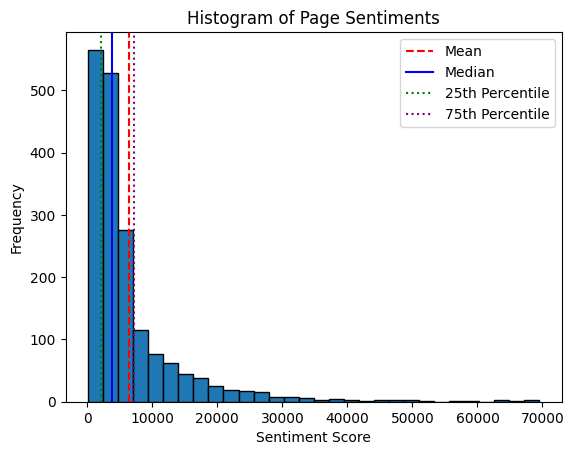

In [158]:
plt.hist(sentiment_values, bins=30, edgecolor='black')
plt.axvline(avg_sentiment, color='red', linestyle='--', label='Mean')
plt.axvline(median_sentiment, color='blue', linestyle='-', label='Median')
plt.axvline(percentile_25, color='green', linestyle=':', label='25th Percentile')
plt.axvline(percentile_75, color='purple', linestyle=':', label='75th Percentile')
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.legend()
plt.title("Histogram of Page Sentiments")
plt.show()

Analyzing the distribution in the plot above, along with the previous statistics, reveals a greater concentration of lower sentiment values. This indecates that most artist pages contain words ranked lower on the happiness scale. Thus, we can consider that overall the artist in this genres create more sad than happy content.

Additionally, in the following cell, we identified and printed the 10 happiest and 10 saddest artists along with their respective sentiment scores.

In [160]:
sorted_sentiments = sorted(artist_data_sentiment.items(), key=lambda x: x[1])
saddest_artists = sorted_sentiments[:10]
happiest_artists = sorted_sentiments[-10:]
happiest_artists = happiest_artists[::-1]

print('Top 10 Happiest Artists:')
for i in range(len(happiest_artists)):
    artist, sentiment = happiest_artists[i]
    print(f'{artist} {sentiment}')

print('\nTop 10 Saddest Artists:')
for i in range(len(saddest_artists)):
    artist, sentiment = saddest_artists[i]
    print(f'{artist} {sentiment}')

Top 10 Happiest Artists:
Bob Dylan 69479.65
Beyoncé 69050.7
Justin Bieber 65495.45
Carrie Underwood 64179.02
Taylor Swift 64050.76
Elvis Presley 59711.46
Miley Cyrus 56967.91
Linda Ronstadt 51565.85
Demi Lovato 50747.07
Justin Timberlake 48979.21

Top 10 Saddest Artists:
The Stonemans 155.98
Kortney Kayle 161.42
Corb Lund and the Hurtin' Albertans 161.7
Flatt & Scruggs 161.7
Hanna-McEuen 161.7
Infamous Stringdusters 161.7
JJ Cale 161.7
Raul Malo 167.12
A.P. Carter 167.4
Jason Boland & the Stragglers 171.34


In [ ]:
# Count nodes in each community
community_counts = Counter(partition.values())
top_10_communities = [c for c, _ in community_counts.most_common(10)]

# rename the artist names in the partitions
partition = {artist.replace('_', ' '): c for artist, c in partition.items()}

# Calculate average sentiment for each community
community_sentiments = {}
for community in top_10_communities:
    # Initialize a variable to store the sum of sentiments for the community
    community_sentiment_sum = 0

    # Iterate over each artist in the partition
    for artist in partition:
        # Check if the artist belongs to the current community
        if partition[artist] == community:
            # Add the artist's sentiment to the community's sentiment sum
            community_sentiment_sum += artist_data_sentiment[artist]

    # Calculate the average sentiment for the community and round to 2 decimal places
    community_average_sentiment = round(community_sentiment_sum / community_sizes[community], 2)

    # Store the result in the community_sentiments dictionary
    community_sentiments[community] = community_average_sentiment

print("Community Sentiments:")
for community, sentiment in community_sentiments.items():
    print(f"Community {community} avg sentiment: {sentiment:.2f}")


Community Sentiments:
Community 0 avg sentiment: 4920.40
Community 3 avg sentiment: 7190.37
Community 7 avg sentiment: 7329.87
Community 1 avg sentiment: 7133.59
Community 6 avg sentiment: 5349.96
Community 10 avg sentiment: 4032.62
Community 8 avg sentiment: 3361.94
Community 9 avg sentiment: 2830.19
Community 2 avg sentiment: 4352.14
Community 11 avg sentiment: 2346.75


Community 0; Merle Haggard, Vince Gill, Reba McEntire: Avg Sentiment = 4920.4000
Community 3; Keith Urban, Blake Shelton, Martina McBride: Avg Sentiment = 7190.3700
Community 7; Emmylou Harris, Bob Dylan, Dwight Yoakam: Avg Sentiment = 7329.8700
Community 1; Willie Nelson, Johnny Cash, Elvis Presley: Avg Sentiment = 7133.5900
Community 6; Gord Bamford, Kasey Chambers, Beccy Cole: Avg Sentiment = 5349.9600
Community 10; The Chicks, Keith Gattis, Jack Ingram: Avg Sentiment = 4032.6200
Community 8; George Canyon, Aaron Pritchett, One More Girl: Avg Sentiment = 3361.9400
Community 9; South 65, Mark McGuinn, Rio Grand: Avg Sentiment = 2830.1900
Community 2; Trailer Choir, Carter's Chord, Stephen Cochran: Avg Sentiment = 4352.1400
Community 11; honeyhoney: Avg Sentiment = 2346.7500

Three Saddest Communities:
1) honeyhoney: Avg Sentiment = 2346.7500
2) South 65, Mark McGuinn, Rio Grand: Avg Sentiment = 2830.1900
3) George Canyon, Aaron Pritchett, One More Girl: Avg Sentiment = 3361.9400

Thr

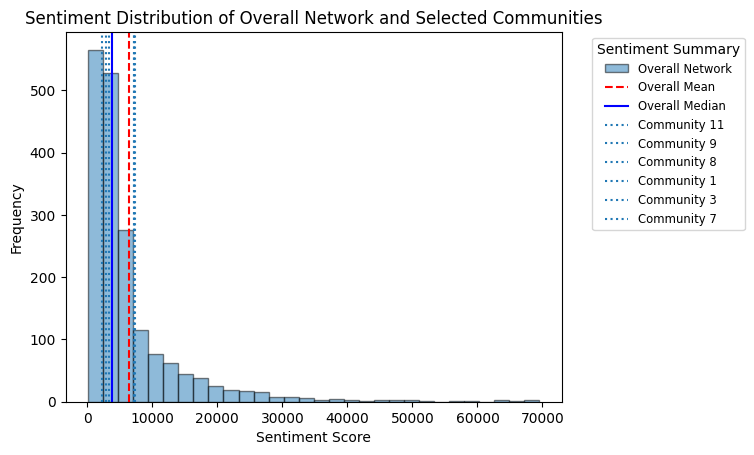

In [195]:
community_names = {}
for c in top_10_communities:
    # Get nodes in the community
    community_nodes = [node for node, comm in partition.items() if comm == c]
    # rename the nodes in community_nodes
    community_nodes = [node.replace(' ', '_') for node in community_nodes]
    community_degrees = G.degree(community_nodes)
    # Sort nodes by degree
    sorted_community = sorted(community_degrees, key=lambda x: x[1], reverse=True)
    community_names[c] = [node for node, degree in sorted_community[:3]]

for c, name in community_names.items():
    print(f"Community {c}; {', '.join(name).replace('_', ' ')}: Avg Sentiment = {community_sentiments[c]:.4f}")

# Determine the happiest and saddest communities
sorted_communities = sorted(community_sentiments.items(), key=lambda x: x[1])

# Happiest and saddest communities
saddest_communities = sorted_communities[:3]
happiest_communities = sorted_communities[-3:]

print("\nThree Saddest Communities:")
i = 1
for c, sentiment in saddest_communities:
    print(f"{i}) {', '.join(community_names[c]).replace('_', ' ')}: Avg Sentiment = {sentiment:.4f}")
    i += 1

print("\nThree Happiest Communities:")
i = 1
for c, sentiment in happiest_communities:
    print(f"{i}) {', '.join(community_names[c]).replace('_', ' ')}: Avg Sentiment = {sentiment:.4f}")
    i += 1

# Compare to overall sentiment
print(f"\nOverall Network Average Sentiment: {avg_sentiment:.4f}")
print(f"Overall Network Median Sentiment: {median_sentiment:.4f}")


plt.hist(sentiment_values, bins=30, edgecolor='black', alpha=0.5, label='Overall Network')
plt.axvline(avg_sentiment, color='red', linestyle='--', label='Overall Mean')
plt.axvline(median_sentiment, color='blue', linestyle='-', label='Overall Median')

# Add sentiment lines for each of the happiest and saddest communities
for c, sentiment in saddest_communities + happiest_communities:
    plt.axvline(community_sentiments[c], linestyle=':', label=f"Community {c}")

plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Sentiment Distribution of Overall Network and Selected Communities")

# Adjust the legend to be outside of the plot and more readable
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title="Sentiment Summary")

plt.show()

#### **Discuss the sentiment of the largest communities.**

The sentiment analysis shows a strong emotional contrast between different music communities, with some leaning toward somber themes and others favoring more uplifting tones. In the saddest communities, Honeyhoney ranks as the most melancholic with a low sentiment score of 2346.75, hinting at introspective themes often found in folk and Americana music. Other communities, like those featuring South 65, Mark McGuinn, Rio Grand, and George Canyon, Aaron Pritchett, One More Girl, also display lower scores, suggesting reflective or emotionally heavy content.

On the other hand, the happiest communities, including legends like Willie Nelson, Johnny Cash, and Elvis Presley, have notably higher sentiment scores, pointing to an overall positive, sometimes celebratory tone in their music. Communities surrounding Keith Urban, Blake Shelton, Martina McBride, along with Emmylou Harris, Bob Dylan, and Dwight Yoakam, similarly embrace upbeat themes, often blending country, folk, and rock with a hopeful or optimistic outlook. This contrast captures the emotional depth within country music, which spans from life’s struggles to its joys.

#### **Do the findings using TF-IDF during Lecture 7 help you understand your results?**


The TF-IDF findings from Lecture 7 shed light on why certain communities have these contrasting sentiments. By highlighting each community's unique vocabulary, TF-IDF shows how some groups emphasize words associated with struggle and hardship, while others feature more uplifting or neutral language. This focus on distinctive vocabulary helps explain the sentiment differences: saddest communities gravitate toward themes that carry a heavier emotional weight, while the happiest communities reflect a more positive, life-affirming tone. Together, TF-IDF and sentiment analysis offer a nuanced view of the network's emotional landscape, showing how each community's language captures its unique character and emotional focus.